In [1]:
%matplotlib inline
import numpy as np
import os
from lmfit import Parameters, Minimizer
from astropy.io import fits
import scipy.interpolate as interp
import pickle

import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

from ctisim.fitting import SimpleModel, SimulatedModel
from ctisim import ITL_AMP_GEOM, SplineTrap
from ctisim.utils import OverscanParameterResults

from ctisim.matrix import electronics_operator, trap_operator

error = 7.0/np.sqrt(2000.)
num_transfers = ITL_AMP_GEOM.nx + ITL_AMP_GEOM.prescan_width
ncols = num_transfers

# Fit Fast Release Component

In [30]:
sensor_id = 'R02_S02'

infile = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6790D_linearity/R02/S02/{0}_overscan_results.fits'.format(sensor_id)
hdulist = fits.open(infile)

start = 1
stop = 20
max_signal = 150000.
param_results = OverscanParameterResults.from_fits('{0}_parameter_results.fits'.format(sensor_id))
print(param_results.cti_results)

{1: 4.380591e-07, 2: 6.3274217e-07, 3: 1.0898464e-06, 4: 7.7181943e-07, 5: 7.105179e-07, 6: 5.8464656e-07, 7: 3.7930295e-07, 8: 8.097616e-06, 9: 2.0932428e-06, 10: 6.0630697e-07, 11: 7.6456223e-07, 12: 6.3798876e-07, 13: 7.291024e-07, 14: 7.134694e-07, 15: 6.372703e-07, 16: 4.575973e-07}


In [31]:
spltraps = {}
for amp in range(1, 17):

    ## Signals
    all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
    signals = all_signals[all_signals<max_signal]

    ## Data
    data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, start:stop+1]

    ## Second model: model with electronics
    params = Parameters()
    params.add('ctiexp', value=np.log10(param_results.cti_results[amp]), min=-7, max=-5, vary=False)
    params.add('trapsize', value=0.0, min=0., max=10., vary=False)
    params.add('scaling', value=0.08, min=0, max=1.0, vary=False)
    params.add('emissiontime', value=0.35, min=0.1, max=1.0, vary=False)
    params.add('driftscale', value=param_results.drift_scales[amp], min=0., max=0.001, vary=False)
    params.add('decaytime', value=param_results.decay_times[amp], min=0.1, max=4.0, vary=False)
    params.add('threshold', value=param_results.thresholds[amp], min=0.0, max=150000., vary=False)
    model = SimpleModel.model_results(params,signals, num_transfers, start=start, stop=stop)

    res = (data-model)[:, 0]+(data-model)[:, 1]
    new_signals = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, 0]
    rescale = param_results.drift_scales[amp]*np.maximum(np.zeros(new_signals.shape), new_signals-param_results.thresholds[amp])
    new_signals = np.asarray(new_signals - rescale, dtype=np.float64)
    x = new_signals
    y = np.maximum(0, res)

    # Pad left with ramp
    y = np.pad(y, (10, 0), 'linear_ramp', end_values=(0, 0))
    x = np.pad(x, (10, 0), 'linear_ramp', end_values=(0, 0))

    # Pad right with constant
    y = np.pad(y, (1, 1), 'constant', constant_values=(0, y[-1]))
    x = np.pad(x, (1, 1), 'constant', constant_values=(-1, 200000.))

    f = interp.interp1d(x, y)
    spltrap = SplineTrap(f, 0.4, 1)
    pickle.dump(spltrap, open('{0}_amp{1}_traps.pkl'.format(sensor_id, amp), 'wb'))
    spltraps[amp] = spltrap

# Test Correction

In [32]:
## Correction
corrected = {}
for amp in range(1, 17):
    
    all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
    signals = all_signals[all_signals<max_signal]
    data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, :]

    imarr = np.zeros((data.shape[0], ncols+data.shape[1]-1))
    ramp = np.tile(signals, (ITL_AMP_GEOM.nx-1, 1)).T
    imarr[:, ITL_AMP_GEOM.prescan_width:ncols-1] = ramp
    imarr[:, ncols-1:] = data

    E = electronics_operator(imarr, param_results.drift_scales[amp],
                             param_results.decay_times[amp],
                             param_results.thresholds[amp],
                             num_previous_pixels=15)

    corrected_electronics = imarr-E

    T, R, C = trap_operator(corrected_electronics, spltraps[amp])
    corrected[amp] = corrected_electronics-(1-param_results.cti_results[amp])T

SyntaxError: invalid syntax (<ipython-input-32-44f03fc6ed57>, line 22)

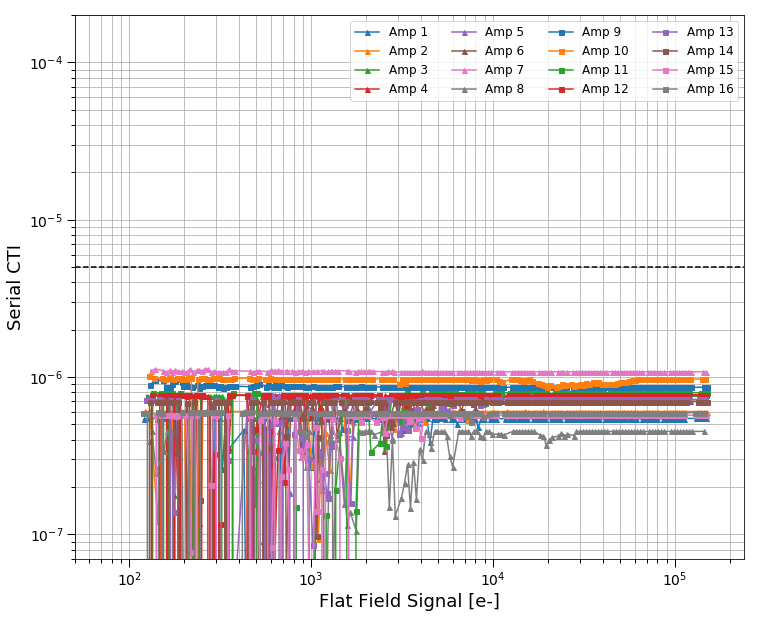

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
cmap = plt.get_cmap("tab10")

for amp in range(1, 17):

    if amp > 8: marker='s'
    else: marker = '^'

    signal = np.mean(corrected[amp][:, 50:450], axis=1)
    lastpixel = corrected[amp][:, 511]
    overscan1 = corrected[amp][:, 512]
    overscan2 = corrected[amp][:, 513]
    cti = (overscan1+overscan2)/(num_transfers*lastpixel)

    ax.plot(signal, cti, label='Amp {0}'.format(amp), 
            color = cmap((amp-1)%8), marker=marker, markersize=5)

ax.axhline(y=5.E-6, linestyle='--', color='black')

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='both', which='major', length=8, width=1)
ax.tick_params(axis='both', which='minor', length=4, width=1)
ax.set_ylim(bottom=7E-8, top=2E-4)
ax.set_xlim(left=50.0, right=240000.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, which='both', axis='both')
ax.set_xlabel('Flat Field Signal [e-]', fontsize=18)
ax.set_ylabel('Serial CTI', fontsize=18)
ax.legend(fontsize=12, loc=1, ncol=4)

Text(0.5, 0, 'Flat Field Signal [e-]')

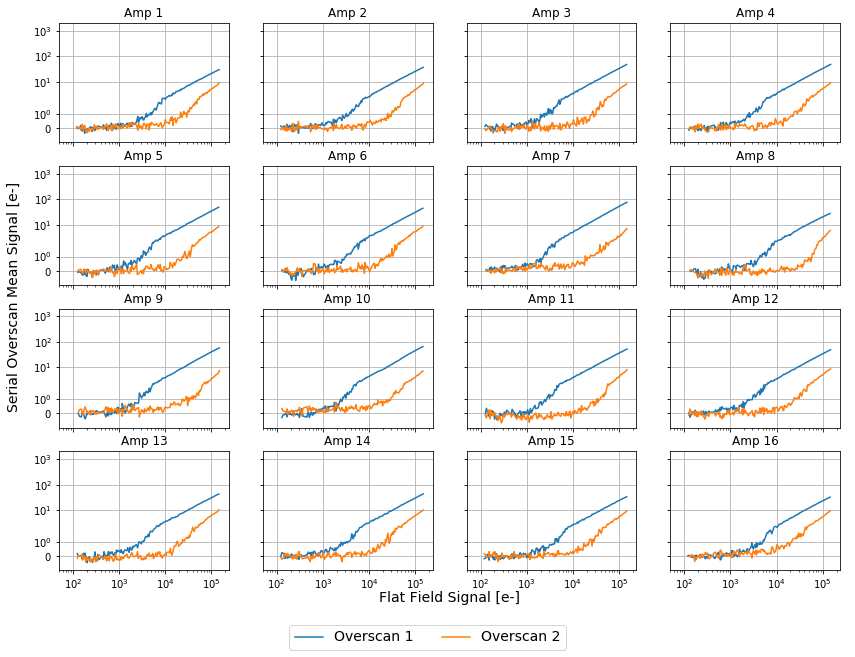

In [29]:
fig, axes = plt.subplots(4, 4, sharey=True, sharex=True, figsize=(14, 10))
axes = axes.flatten()

for amp in range(1, 17):

    signal = np.mean(corrected[amp][:, 50:450], axis=1)
    overscan1 = corrected[amp][:, 512]
    overscan2 = corrected[amp][:, 513]

    axes[amp-1].plot(signal, overscan1, label='Overscan 1'.format(amp))
    axes[amp-1].plot(signal, overscan2, label='Overscan 2'.format(amp))

    axes[amp-1].set_yscale('symlog', threshold=1.0)
    axes[amp-1].set_xscale('log')
    axes[amp-1].set_ylim(bottom=-1.0, top=2000.)
    axes[amp-1].set_xlim(left=50, right=240000)
    axes[amp-1].set_title('Amp {0}'.format(amp), fontsize=12)
    axes[amp-1].grid(True, which='major', axis='both')

h, l = axes[-1].get_legend_handles_labels()
fig.subplots_adjust(bottom=0.12)
fig.legend(h, l, loc='lower center', ncol=2, fontsize=14)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, 
                left=False, right=False)
plt.ylabel('Serial Overscan Mean Signal [e-]', fontsize=14, labelpad=15)
plt.xlabel('Flat Field Signal [e-]', fontsize=14)

# Check Problem Amplifiers

In [7]:
amp = 13

## Signals
all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
signals = all_signals[all_signals<max_signal]

## Data
data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, start:stop+1]

## Second model: model with electronics
params = Parameters()
params.add('ctiexp', value=np.log10(param_results.cti_results[amp]), min=-7, max=-5, vary=False)
params.add('trapsize', value=0.0, min=0., max=10., vary=False)
params.add('scaling', value=0.08, min=0, max=1.0, vary=False)
params.add('emissiontime', value=0.35, min=0.1, max=1.0, vary=False)
params.add('driftscale', value=param_results.drift_scales[amp], min=0., max=0.001, vary=False)
params.add('decaytime', value=param_results.decay_times[amp], min=0.1, max=4.0, vary=False)
params.add('threshold', value=param_results.thresholds[amp], min=0.0, max=150000., vary=False)
model = SimpleModel.model_results(params,signals, num_transfers, start=start, stop=stop)
print(params)

res = (data-model)[:, 0]

rescale = param_results.drift_scales[amp]*np.maximum(np.zeros(signals.shape), signals-param_results.thresholds[amp])
new_signals = np.asarray(signals - rescale, dtype=np.float64)
x = new_signals
y = np.maximum(0, res)

# Pad left with ramp
y = np.pad(y, (10, 0), 'linear_ramp', end_values=(0, 0))
x = np.pad(x, (10, 0), 'linear_ramp', end_values=(0, 0))

# Pad right with constant
y = np.pad(y, (0, 1), 'constant', constant_values=(0, y[-1]))
x = np.pad(x, (0, 1), 'constant', constant_values=(0, 200000.))

f = interp.interp1d(x, y)
spltrap = SplineTrap(f, 0.4, 1)

Parameters([('ctiexp', <Parameter 'ctiexp', value=-6.1372113 (fixed), bounds=[-7:-5]>), ('trapsize', <Parameter 'trapsize', value=0.0 (fixed), bounds=[0.0:10.0]>), ('scaling', <Parameter 'scaling', value=0.08 (fixed), bounds=[0:1.0]>), ('emissiontime', <Parameter 'emissiontime', value=0.35 (fixed), bounds=[0.1:1.0]>), ('driftscale', <Parameter 'driftscale', value=0.00015891776 (fixed), bounds=[0.0:0.001]>), ('decaytime', <Parameter 'decaytime', value=2.53488 (fixed), bounds=[0.1:4.0]>), ('threshold', <Parameter 'threshold', value=2.9427949e-05 (fixed), bounds=[0.0:150000.0]>)])


In [8]:
all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
signals = all_signals[all_signals<max_signal]
data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, 1:]

imarr = np.zeros((data.shape[0], ncols+data.shape[1]))
ramp = np.tile(signals, (ITL_AMP_GEOM.nx, 1)).T
imarr[:, ITL_AMP_GEOM.prescan_width:ncols] = ramp
imarr[:, ncols:] = data

E = electronics_operator(imarr, param_results.drift_scales[amp],
                         param_results.decay_times[amp],
                         param_results.thresholds[amp],
                         num_previous_pixels=15)

corrected_electronics = imarr-E

T, R, C = trap_operator(corrected_electronics, spltrap)
corrected = corrected_electronics-T

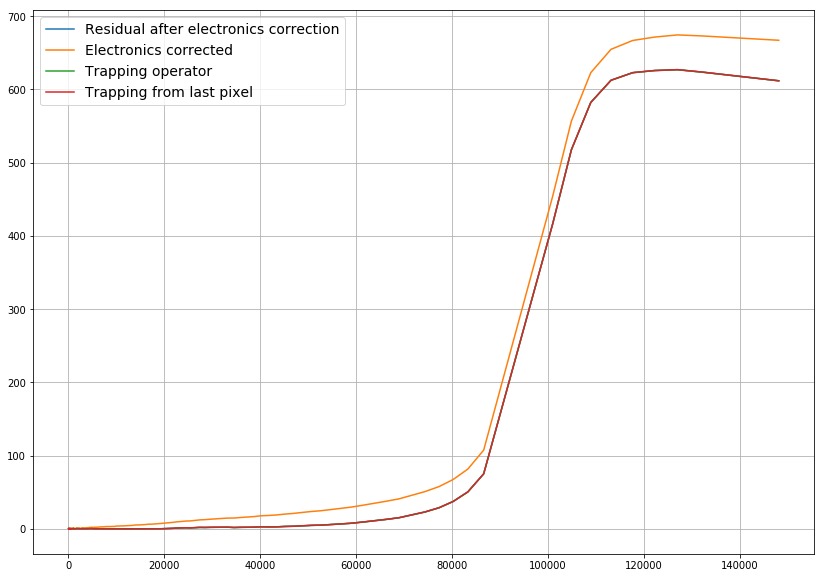

In [9]:
s = np.logspace(2, np.log10(170000.), 500)
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
ax.plot(new_signals, res, label='Residual after electronics correction')
ax.plot(new_signals, corrected_electronics[:, 512], label='Electronics corrected')
ax.plot(new_signals, T[:, 512], label='Trapping operator')
ax.plot(corrected_electronics[:, 511], spltrap.f(corrected_electronics[:, 511]), label='Trapping from last pixel')
ax.legend(fontsize=14)
ax.grid(which='both', axis='both')

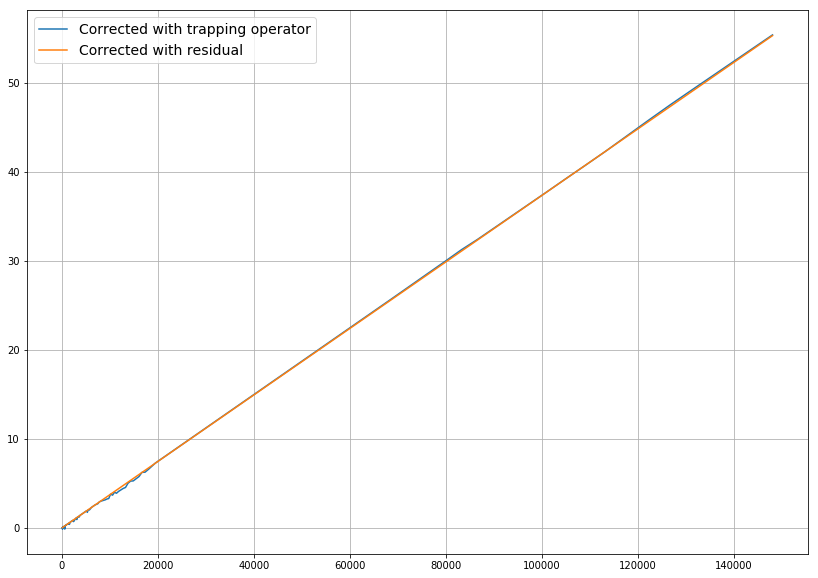

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
ax.plot(new_signals, corrected_electronics[:, 512]-T[:, 512], label='Corrected with trapping operator')
ax.plot(new_signals, corrected_electronics[:, 512]-res, label='Corrected with residual')
ax.legend(fontsize=14)
ax.grid(which='both', axis='both')

# Save for now

In [ ]:
## Script parameters
start = 1
stop = 2
max_signal = 10000.
error = 7.0/np.sqrt(2000.)
num_transfers = ITL_AMP_GEOM.nx + ITL_AMP_GEOM.prescan_width

In [ ]:
## Get electronics parameters
param_results_file = '{0}_parameter_results.fits'.format(sensor_id)
param_results = OverscanParameterResults.from_fits(param_results_file)

cti_results = {amp : 0.0 for amp in range(1, 17)}
drift_scales = param_results.drift_scales
decay_times = param_results.decay_times
thresholds = param_results.thresholds

for amp in range(1, 17):

    ## Signals
    all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
    signals = all_signals[all_signals<max_signal]

    ## Data
    data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, start:stop+1]

    params = Parameters()
    params.add('ctiexp', value=np.log10(2E-7), min=-7, max=-5, vary=True)
    params.add('trapsize', value=0.0, min=0., max=10., vary=True)
    params.add('scaling', value=0.08, min=0, max=1.0, vary=False)
    params.add('emissiontime', value=0.35, min=0.1, max=1.0, vary=True)
    params.add('driftscale', value=drift_scales[amp], min=0., max=0.001, vary=False)
    params.add('decaytime', value=decay_times[amp], min=0.1, max=4.0, vary=False)
    params.add('threshold', value=thresholds[amp], min=0.0, max=150000., vary=False)

    model = SimpleModel()

    minner = Minimizer(model.difference, params, fcn_args=(signals, data, error, num_transfers),
                           fcn_kws={'start' : start, 'stop' : stop})
    result = minner.minimize()

    if result.params['trapsize'] < 1.0:
        params = Parameters()
        params.add('ctiexp', value=-6, min=-7, max=-5, vary=True)
        params.add('trapsize', value=0.0, min=0., max=10., vary=False)
        params.add('scaling', value=0.08, min=0, max=1.0, vary=False)
        params.add('emissiontime', value=0.4, min=0.1, max=1.0, vary=False)
        params.add('driftscale', value=drift_scales[amp], min=0., max=0.001, vary=False)
        params.add('decaytime', value=decay_times[amp], min=0.1, max=4.0, vary=False)
        params.add('threshold', value=thresholds[amp], min=0.0, max=150000., vary=False)

        model = SimpleModel()

        minner = Minimizer(model.difference, params, fcn_args=(signals, data, error, num_transfers),
                               fcn_kws={'start' : start, 'stop' : stop})
        result = minner.minimize()
        cti_results[amp] = 10**result.params['ctiexp']
    else:
        params = Parameters()
        params.add('ctiexp', value=-6, min=-7, max=-5, vary=True)
        params.add('trapsize', value=3.0, min=0., max=10., vary=True)
        params.add('scaling', value=0.08, min=0, max=1.0, vary=True)
        params.add('emissiontime', value=0.35, min=0.1, max=1.0, vary=True)
        params.add('driftscale', value=drift_scales[amp], min=0., max=0.001, vary=False)
        params.add('decaytime', value=decay_times[amp], min=0.1, max=4.0, vary=False)
        params.add('threshold', value=thresholds[amp], min=0.0, max=150000., vary=False)

        model = SimpleModel()

        minner = Minimizer(model.difference, params, fcn_args=(signals, data, error, num_transfers),
                               fcn_kws={'start' : start, 'stop' : stop})
        result = minner.minimize()
        cti_results[amp] = 10**result.params['ctiexp']

#param_results.cti_results = cti_results
#param_results.write_fits(param_results_file, overwrite=True)
print(param_results.cti_results)

## Inform from corrected data

Can fit the fast release component from the corrected data, but this will also necessarily capture the CTI.

In [ ]:
## Signals
all_signals = hdulist[amp].data['FLATFIELD_SIGNAL']
signals = all_signals[all_signals<max_signal]

## Data
data = hdulist[amp].data['COLUMN_MEAN'][all_signals<max_signal, start:stop+1]

imarr = np.zeros((data.shape[0], ncols+data.shape[1]))
ramp = np.tile(signals, (ITL_AMP_GEOM.nx, 1)).T
imarr[:, ITL_AMP_GEOM.prescan_width:ncols] = ramp
imarr[:, ncols:] = data

## First model: data with electronics correction
E = electronics_operator(imarr, param_results.drift_scales[amp],
                         param_results.decay_times[amp],
                         param_results.thresholds[amp],
                         num_previous_pixels=15)
model1 = imarr-E

new_signals1 = np.mean(model1[:, 50:450], axis=1)
x = new_signals1
y = np.maximum(0, model1[:, 512])

# Pad left with ramp
y = np.pad(y, (10, 0), 'linear_ramp', end_values=(0, 0))
x = np.pad(x, (10, 0), 'linear_ramp', end_values=(0, 0))

# Pad right with constant
y = np.pad(y, (1, 1), 'constant', constant_values=(0, y[-1]))
x = np.pad(x, (1, 1), 'constant', constant_values=(-1, 200000.))

f = interp.interp1d(x, y)
spltrap1 = SplineTrap(f, 0.4, 1)

## Correction
T, R, C = trap_operator(model1, spltrap1)
corrected1 = model1-T

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.plot(new_signals1, model1[:, 512]-spltrap1.f(new_signals1), 'red')
ax.plot(new_signals1, corrected1[:, 512], 'blue')
ax.grid(which='both', axis='both')